# Demand Forecasting

One of the largest retail chains in the world wants to use its vast data source to build an efficient forecasting model to predict the sales for each SKU in its portfolio at its 76 different stores using historical sales data for the past 3 years on a week-on-week basis. Sales and promotional information is also available each week, both product and store-wise.

However, no other information regarding stores and products is available. Can we still accurately forecast the sales values for every such product/SKU-store combination for the next 12 weeks? 

## Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import sklearn as sk

In [4]:
df = pd.read_csv('demand_planning.csv')
df.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52


In [5]:
df.shape

(150150, 9)

In [6]:
# format weeek column - extract day, week, month and drop str
df[['Day','Month','Year']]=df['week'].str.split('/', expand = True)
df = df.drop('week',axis = 1)

## Create Preliminary Model

In [8]:
#import sklearn and required libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X,y = df.drop('units_sold', axis = 1), df['units_sold']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2,random_state =42)

In [9]:
# Basic model evaluation
model = RandomForestRegressor(n_jobs=-1)
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1)

In [10]:
# calculate R2
model.score(X_test, y_test)

0.7748051874785615

In [11]:
from sklearn.metrics import root_mean_squared_error

In [12]:
y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_pred, y_test)
rmse
# prediction of units sold 

27.18257881062558

In [13]:
df.units_sold.describe()

count    150150.000000
mean         51.674206
std          60.207904
min           1.000000
25%          20.000000
50%          35.000000
75%          62.000000
max        2876.000000
Name: units_sold, dtype: float64

<Axes: xlabel='units_sold'>

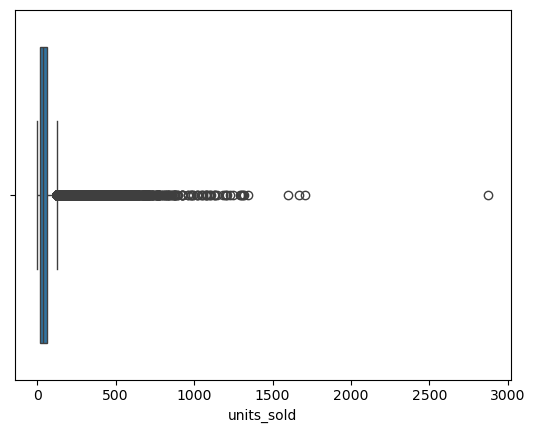

In [14]:
# outlier detection

sns.boxplot(data = df, x= 'units_sold')

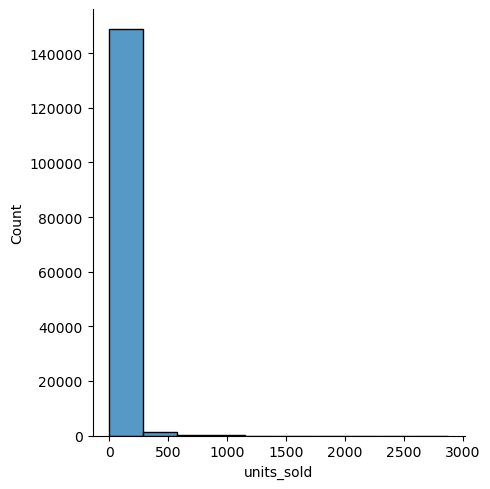

In [15]:
sns.displot(data = df, x = 'units_sold', bins = 10)

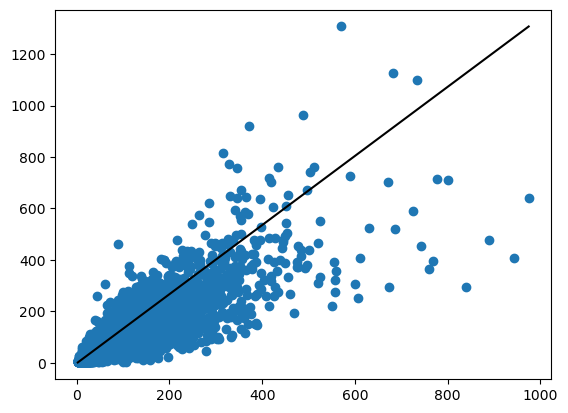

In [16]:
plt.scatter( x= y_pred, y = y_test)
plt.plot(np.linspace( y_pred.min(), y_pred.max()), np.linspace( y_test.min(), y_test.max()), color = 'black')

## Initial finding prior to preprocessing

#### The prediction s not currrently a good fit.  Early inidications demonstarte that althought the bulk of units sold were between 0-500, there are also ouliers in the between 600 and 1300 units sold.

In [19]:
df = df.drop('record_ID',axis = 1)
df.head()

,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,Day,Month,Year
0,8091,216418,99.0375,111.8625,0,0,20,17,01,11
1,8091,216419,99.0375,99.0375,0,0,28,17,01,11
2,8091,216425,133.9500,133.9500,0,0,19,17,01,11
3,8091,216233,133.9500,133.9500,0,0,44,17,01,11
4,8091,217390,141.0750,141.0750,0,0,52,17,01,11


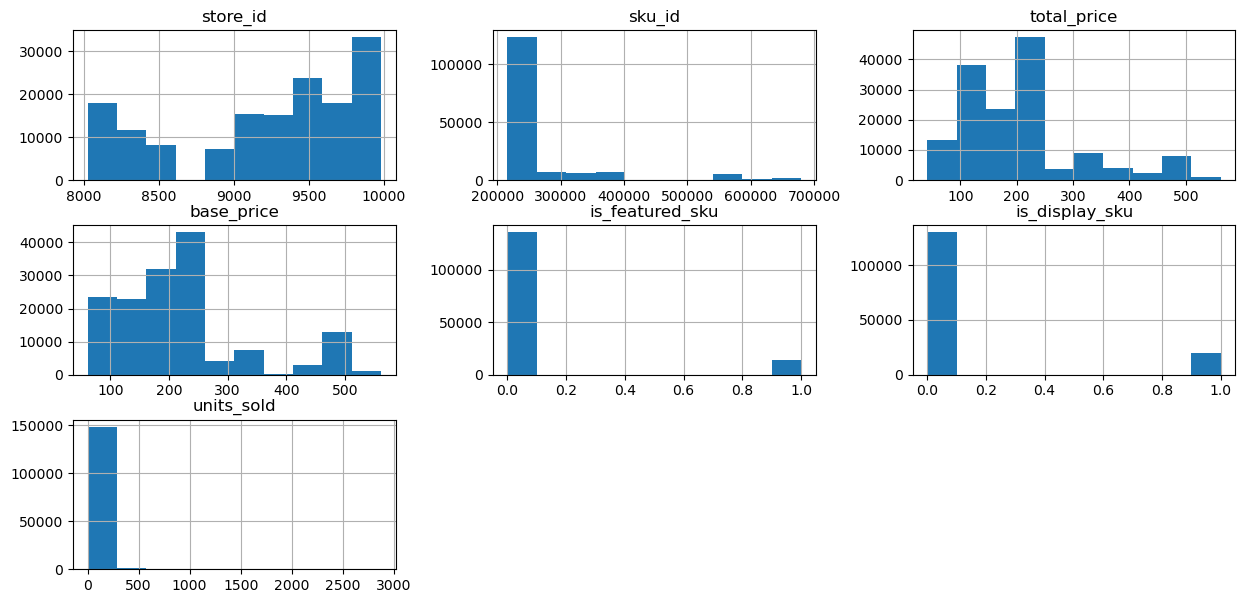

In [20]:
# distrubtutions
df.hist(figsize = (15,7))
plt.show()


In [21]:
# store_id and sku id are not numerical featrures -  (one hot encoding)
# remove outliers from units sold for better distribution 

In [22]:
len(df.sku_id.unique())

28

In [23]:
len(df.store_id.unique())

76

In [24]:
# drop units over 99th percentile
df = df[df.units_sold<df.units_sold.quantile(0.99)]
df

,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,Day,Month,Year
0,8091,216418,99.0375,111.8625,0,0,20,17,01,11
1,8091,216419,99.0375,99.0375,0,0,28,17,01,11
2,8091,216425,133.9500,133.9500,0,0,19,17,01,11
3,8091,216233,133.9500,133.9500,0,0,44,17,01,11
4,8091,217390,141.0750,141.0750,0,0,52,17,01,11
...,...,...,...,...,...,...,...,...,...,...
150145,9984,223245,235.8375,235.8375,0,0,38,09,07,13
150146,9984,223153,235.8375,235.8375,0,0,30,09,07,13
150147,9984,245338,357.6750,483.7875,1,1,31,09,07,13
150148,9984,547934,141.7875,191.6625,0,1,12,09,07,13


<Axes: >

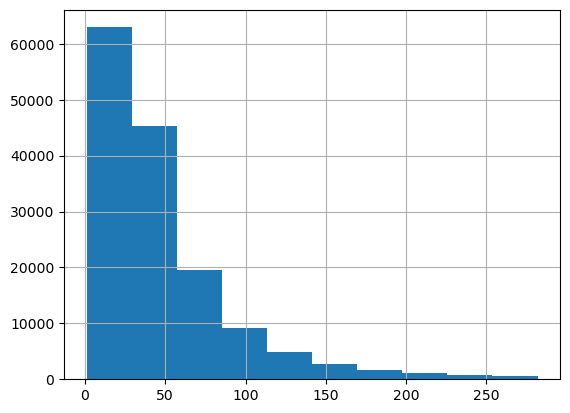

In [25]:
df.units_sold.hist()

In [26]:
# We have removed 1514 units_sold - distribution look much healthier

In [27]:
df.join(pd.get_dummies(df.store_id, prefix = 'store',)).drop('store_id', axis =1)
df.join(pd.get_dummies(df.store_id, prefix = 'item',)).drop('sku_id', axis =1)

,store_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,Day,Month,Year,item_8023,...,item_9872,item_9876,item_9879,item_9880,item_9881,item_9890,item_9909,item_9954,item_9961,item_9984
0,8091,99.0375,111.8625,0,0,20,17,01,11,False,...,False,False,False,False,False,False,False,False,False,False
1,8091,99.0375,99.0375,0,0,28,17,01,11,False,...,False,False,False,False,False,False,False,False,False,False
2,8091,133.9500,133.9500,0,0,19,17,01,11,False,...,False,False,False,False,False,False,False,False,False,False
3,8091,133.9500,133.9500,0,0,44,17,01,11,False,...,False,False,False,False,False,False,False,False,False,False
4,8091,141.0750,141.0750,0,0,52,17,01,11,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150145,9984,235.8375,235.8375,0,0,38,09,07,13,False,...,False,False,False,False,False,False,False,False,False,True
150146,9984,235.8375,235.8375,0,0,30,09,07,13,False,...,False,False,False,False,False,False,False,False,False,True
150147,9984,357.6750,483.7875,1,1,31,09,07,13,False,...,False,False,False,False,False,False,False,False,False,True
150148,9984,141.7875,191.6625,0,1,12,09,07,13,False,...,False,False,False,False,False,False,False,False,False,True


In [28]:
model2 = RandomForestRegressor(n_jobs=-1)
X, y= df.drop('units_sold', axis =1), df['units_sold']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2,random_state =42)

In [29]:
model2.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1)

In [30]:
model2.score(X_test, y_test)

0.8080453291219671

In [31]:
y_pred = model2.predict(X_test)
rmse = root_mean_squared_error(y_pred, y_test)
rmse

18.70199530560645

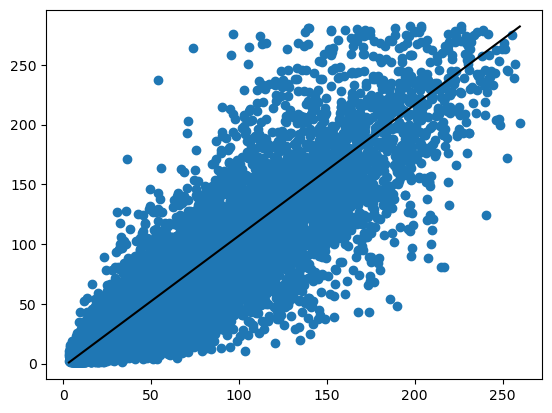

In [32]:
plt.scatter( x= y_pred, y = y_test)
plt.plot(np.linspace( y_pred.min(), y_pred.max()), np.linspace( y_test.min(), y_test.max()), color = 'black')

In [33]:
# Hyperparameter Tuning

from sklearn.model_selection import GridSearchCV

In [34]:
param_grid = {
    'n_estimators':[50,200,500],
    'min_samples_split' : [2,5]}

model2 = RandomForestRegressor(n_jobs=-1)
grid_search = GridSearchCV(model2,param_grid, verbose = 2, cv=3)
grid_search.fit (X_train, y_train)
    

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ...............min_samples_split=2, n_estimators=50; total time=   7.3s
[CV] END ...............min_samples_split=2, n_estimators=50; total time=   6.6s
[CV] END ...............min_samples_split=2, n_estimators=50; total time=   5.8s
[CV] END ..............min_samples_split=2, n_estimators=200; total time=  24.2s
[CV] END ..............min_samples_split=2, n_estimators=200; total time=  18.3s
[CV] END ..............min_samples_split=2, n_estimators=200; total time=  18.9s
[CV] END ..............min_samples_split=2, n_estimators=500; total time=  54.8s
[CV] END ..............min_samples_split=2, n_estimators=500; total time=  51.8s
[CV] END ..............min_samples_split=2, n_estimators=500; total time=  46.2s
[CV] END ...............min_samples_split=5, n_estimators=50; total time=   3.6s
[CV] END ...............min_samples_split=5, n_estimators=50; total time=   4.0s
[CV] END ...............min_samples_split=5, n_es

GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1),
             param_grid={'min_samples_split': [2, 5],
                         'n_estimators': [50, 200, 500]},
             verbose=2)

In [72]:
best_model=grid_search.best_estimator_
best_model

RandomForestRegressor(min_samples_split=5, n_estimators=500, n_jobs=-1)

In [36]:
grid_search.best_params_

{'min_samples_split': 5, 'n_estimators': 500}

In [37]:
best_model.score(X_test, y_test)

0.8095491581930334